In [33]:
%pylab inline
import pandas as pd
from sys import platform
import matplotlib.pyplot as plt

if platform == "win32":
    path = 'C:/Users/olive/GitHub/f1-analytics/'
elif platform == "darwin":
    path = '~/Documents/GitHub/f1-analytics/'
    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [34]:
### Load race and mereged DataFrames

data = pd.read_csv(path + 'data/results.csv')
merged = pd.read_csv(path + 'data/merged.csv')

In [35]:
test = data.copy()

In [36]:
test.query('season == 2021 & round == 6')

,season,round,circuit_id,driver,date_of_birth,nationality,constructor,grid,time,status,points,podium,fastest_lap
2927,2021,6,baku,sergio_perez,1990-01-26,Mexican,red_bull,6,8016410.0,Finished,25.0,1,1:44.687
2928,2021,6,baku,sebastian_vettel,1987-07-03,German,aston_martin,11,8017795.0,Finished,18.0,2,1:44.890
2929,2021,6,baku,pierre_gasly,1996-02-07,French,alphatauri,4,8019172.0,Finished,15.0,3,1:45.220
2930,2021,6,baku,charles_leclerc,1997-10-16,Monegasque,ferrari,1,8020238.0,Finished,12.0,4,1:45.382
2931,2021,6,baku,lando_norris,1999-11-13,British,mclaren,9,8021164.0,Finished,10.0,5,1:45.326
2932,2021,6,baku,fernando_alonso,1981-07-29,Spanish,alpine,8,8022792.0,Finished,8.0,6,1:45.624
2933,2021,6,baku,yuki_tsunoda,2000-05-11,Japanese,alphatauri,7,8023034.0,Finished,6.0,7,1:44.939
2934,2021,6,baku,carlos_sainz,1994-09-01,Spanish,ferrari,5,8024119.0,Finished,4.0,8,1:45.700
2935,2021,6,baku,daniel_ricciardo,1989-07-01,Australian,mclaren,13,8025284.0,Finished,2.0,9,1:45.713
2936,2021,6,baku,kimi_raikkonen,1979-10-17,Finnish,alfa,14,8025986.0,Finished,1.0,10,1:45.601


In [37]:
incidents = test.query(
    'status != "Finished"'
).status.value_counts()

### Only car statuses that did not finish race are included
incidents = incidents[~incidents.index.str.contains('Lap')]

incidents

Collision           129
Accident             67
Engine               66
Brakes               45
Collision damage     44
Power Unit           41
Gearbox              38
Retired              38
Suspension           25
Electrical           13
Hydraulics           13
Power loss           12
Wheel                11
Withdrew             10
Oil leak              9
Spun off              8
Puncture              7
Disqualified          7
Mechanical            6
Water pressure        6
Turbo                 6
Exhaust               5
Battery               5
Overheating           5
ERS                   5
Fuel pressure         5
Tyre                  4
Electronics           4
Water leak            4
Front wing            3
Wheel nut             3
Transmission          3
Undertray             2
Clutch                2
Driveshaft            2
Vibrations            2
Oil pressure          2
Illness               2
Rear wing             2
Throttle              2
Damage                2
Cooling system  

[]

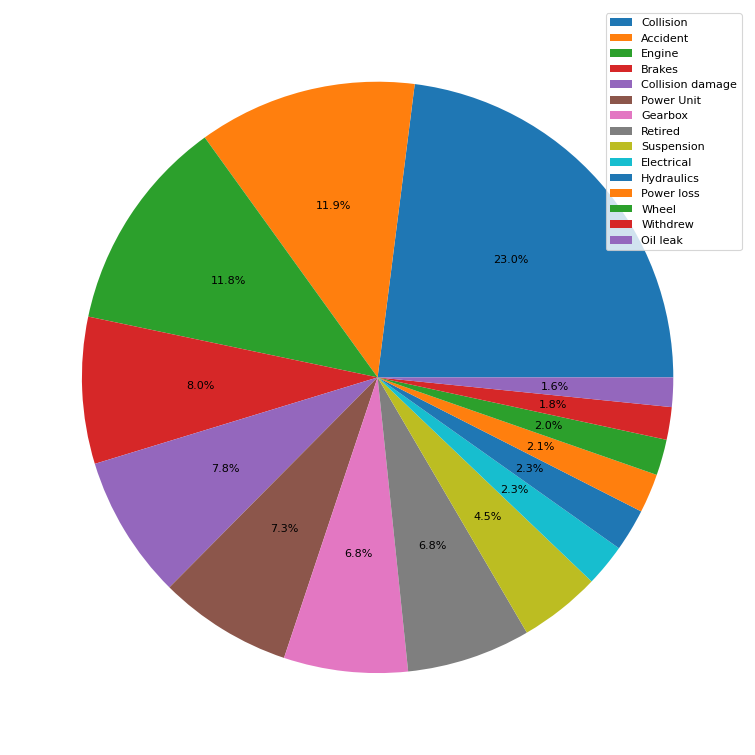

In [38]:
top_incidents = incidents[:15]

fig, axs = plt.subplots(1, dpi=80)
fig.set_size_inches(15, 12)

axs.set_title('')
axs.pie(top_incidents.values, autopct='%1.1f%%')
axs.legend(top_incidents.index, loc=1)
plt.plot()

In [39]:
def format_status(x):
    incident_dict = {
        'Mechanical Failure': ['Differential','Fuel pump','Water pump','Cooling system','Radiator', 'Spark plugs', 'Steering', 'Out of fuel', 'Seat', 'Vibrations','Brake duct','Drivetrain','Fuel system','Technical','Clutch', 'Water leak', 'ERS', 'Battery', 'Tyre', 'Oil pressure', 'Throttle', 'Retired', 'Gearbox', 'Exhaust','Suspension', 'Electronics', 'Wheel', 'Fuel pressure', 'Brakes', 'Engine', 'Overheating', 'Power Unit', 'Mechanical', 'Power loss', 'Water pressure', 'Driveshaft', 'Transmission', 'Electrical', 'Wheel nut', 'Turbo', 'Hydraulics', 'Oil leak'],
        'Collision': ['Fuel leak','Undertray', 'Spun off', 'Front wing', 'Collision damage', 'Accident', 'Collision', 'Debris', 'Puncture', 'Damage', 'Rear wing'],
        'Other': ['Illness', 'Withdrew', 'Disqualified', 'Excluded']
    }
    for col in incident_dict:
        if x in incident_dict[col]:
            return col
    
    return x

In [40]:
data['actual'] = data.status.apply(lambda x: format_status(x))

data.head()

,season,round,circuit_id,driver,date_of_birth,nationality,constructor,grid,time,status,points,podium,fastest_lap,actual
0,2014,1,albert_park,nico_rosberg,1985-06-27,German,mercedes,3,5578710.0,Finished,25.0,1,1:32.478,Finished
1,2014,1,albert_park,kevin_magnussen,1992-10-05,Danish,mclaren,4,5605487.0,Finished,18.0,2,1:33.066,Finished
2,2014,1,albert_park,jenson_button,1980-01-19,British,mclaren,10,5608737.0,Finished,15.0,3,1:32.917,Finished
3,2014,1,albert_park,fernando_alonso,1981-07-29,Spanish,ferrari,5,5613994.0,Finished,12.0,4,1:33.186,Finished
4,2014,1,albert_park,valtteri_bottas,1989-08-28,Finnish,williams,15,5626349.0,Finished,10.0,5,1:32.616,Finished


In [41]:
finished = data[data.actual.str.contains('Finished|Lap')]
dnfs = data[~data.actual.str.contains('Lap|Finished')]

incidents = dnfs.actual.value_counts()

In [42]:
print('Percentage of drivers who DNF a race: {:.2f}%'.format(len(dnfs)/(len(finished)+len(dnfs)) * 100))

Percentage of drivers who DNF a race: 18.37%


[]

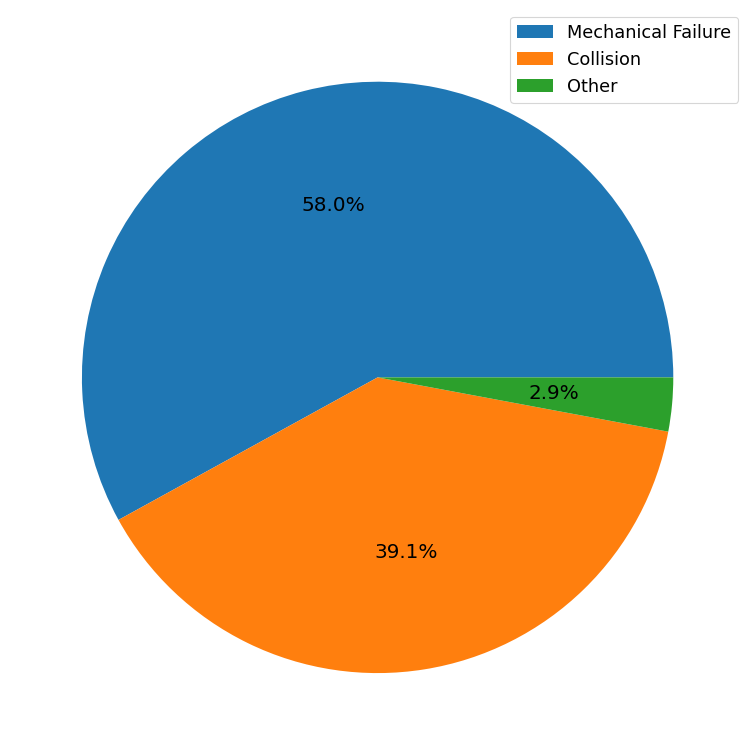

In [43]:
fig, axs = plt.subplots(1, dpi=80)
fig.set_size_inches(15, 12)

axs.set_title('')
axs.pie(incidents.values, autopct='%1.1f%%', textprops={'fontsize': 18})
axs.legend(incidents.index, loc=1, prop={'size': 16})
plt.plot()

In [44]:
race_counts = data.groupby(['season', 'circuit_id']).agg({
    'round': 'nunique'
}).reset_index().groupby('circuit_id').agg({'round': 'sum'}).reset_index()

dnfs_by_circuit = dnfs.groupby('circuit_id').agg({
    'actual': 'count'
    }).reset_index()

dnfs_by_circuit
race_counts

df = pd.merge(dnfs_by_circuit, race_counts, how='inner', on=['circuit_id'])
df.rename(columns = {'actual': 'dnfs', 'round': 'race_count'}, inplace=True)

In [45]:
def calculate_dnf_per_race(row):
    return round(row.dnfs / row.race_count, 2)

In [46]:
df['dnf_per_race'] = df.apply(lambda row: calculate_dnf_per_race(row), axis=1)

average_dnfs_circuits = df.query('race_count > 1').sort_values('dnf_per_race')

In [47]:
average_dnfs_circuits.sort_values('dnf_per_race', ascending=False)

,circuit_id,dnfs,race_count,dnf_per_race
10,jeddah,12,2,6.00
0,albert_park,39,7,5.57
3,baku,31,6,5.17
22,sepang,20,4,5.00
12,marina_bay,33,7,4.71
5,hockenheimring,18,4,4.50
1,americas,35,8,4.38
28,villeneuve,30,7,4.29
14,monaco,34,8,4.25
24,silverstone,42,10,4.20


In [48]:
### Finding any missing circuit_ids

set(list(data.circuit_id.values)) - set(list(dnfs_by_circuit.circuit_id.values))

set()

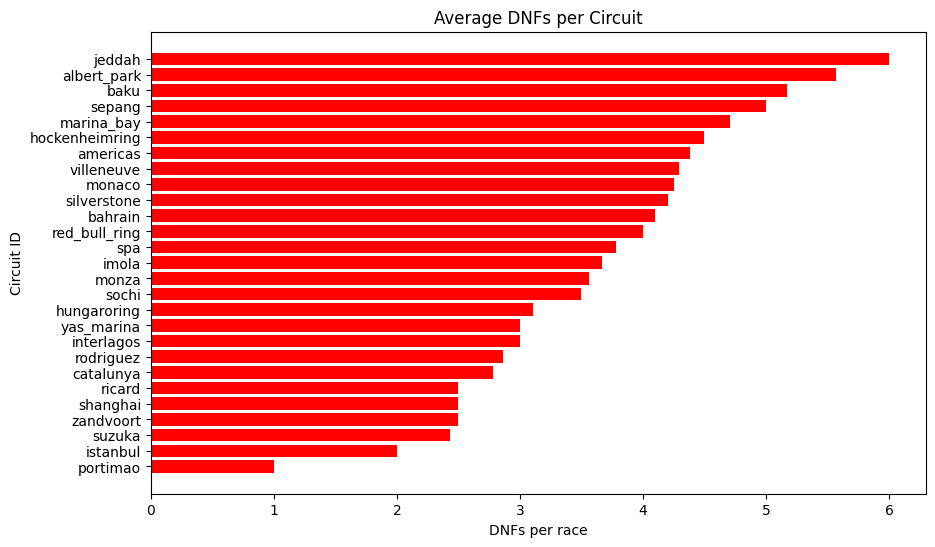

In [49]:
fig, axs = plt.subplots(1, dpi=100)
fig.set_size_inches(10,6)

axs.set_title('Average DNFs per Circuit')
axs.set_xlabel('DNFs per race')
axs.set_ylabel('Circuit ID')
axs.barh(average_dnfs_circuits.circuit_id, average_dnfs_circuits.dnf_per_race, color='r')
plt.show()